In [1]:
import csv 
import networkx as nx
import matplotlib.pyplot as plt
import math
from graph import Graph
from article import Article
import random
import pandas as pd
import seaborn as sns
import mplcursors 
import numpy as np
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore")

In [2]:
cs_graph = Graph()
cs_graph.update_graph("data/categories.tsv", mode='Initialization')
cs_graph.update_graph("data/paths_finished.tsv", mode='common_sense_edges', verbose=True,paths_mode=True) 
cs_graph.update_graph("data/paths_unfinished.tsv", mode='common_sense_edges', verbose=True,paths_mode=True,finished=False)

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
50354 in the articles graph,
6530 in the categories graph,
208 in the topics graph.
The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
57572 in the articles graph,
6931 in the categories graph,
208 in the topics graph.


In [3]:
links_df = pd.read_csv('data/links_df_filtered.csv')

In [4]:
len(links_df)

89080

In [5]:
def divide_column_into_bins(df, column, bin_size):
  # Create the bins
  bins = range(0, int(df[column].max()) + bin_size, bin_size)

  # Create a new column that contains the binned values
  df["binned"] = pd.cut(df[column], bins)

  return df

In [6]:

dict_paths = {}
paths = cs_graph.paths

paths_positions = []
print(len(paths))
groups = links_df.groupby(['article_from','article_to'])
nbr_errors = 0
for i in tqdm(range(0,len(paths)-1)):
    
    pos = []
    relative_pos = []
    for j in range(0,len(paths[i])-1):
        try:
            temp_df = groups.get_group((paths[i][j],paths[i][j+1]))
        except Exception as e:
            nbr_errors += 1
            pos.append(np.nan)
            relative_pos.append(np.nan)
            continue
        pos.append(temp_df['position'].item())
        relative_pos.append(temp_df['relative_position'].item())
    pos_mean = np.nanmean(pos)
    relative_mean = np.nanmean(relative_pos)
    dict_paths[i] = [paths[i],len(paths[i]),pos,pos_mean,relative_pos,relative_mean,cs_graph.finished[i]]
print(nbr_errors)

76193


100%|██████████| 76192/76192 [00:16<00:00, 4694.16it/s]

149486


In [7]:
paths_df = pd.DataFrame.from_dict(dict_paths, orient='index', columns=['paths', 'path_length', 'link_positions','position_mean','relative_pos','relative_mean','finished'])

In [8]:
paths_df.sample(10)

,paths,path_length,link_positions,position_mean,relative_pos,relative_mean,finished
61472,"[Ununbium, Chemical_element]",2,[6],6.000000,[43.0],43.000000,False
29511,"[Iron_Maiden, United_States, Cinema_of_the_Uni...",5,"[2, nan, 16, 1]",6.333333,"[17.0, nan, 53.0, 4.0]",24.666667,True
44077,"[Niue, New_Zealand, Europe, Ireland, Eurovisio...",5,"[nan, 18, nan, 57]",37.500000,"[nan, 21.0, nan, 80.0]",50.500000,True
15324,"[Brain, Computer_science, Physics, Science, Ch...",7,"[nan, 9, nan, nan, nan, 116]",62.500000,"[nan, 53.0, nan, nan, nan, 87.0]",70.000000,True
21490,"[The_Marriage_of_Figaro, Wolfgang_Amadeus_Moza...",5,"[nan, 4, nan, 5]",4.500000,"[nan, 12.0, nan, 19.0]",15.500000,True
34300,"[American_Samoa, English_language, United_Nati...",6,"[0, nan, 102, nan, nan]",51.000000,"[0.0, nan, 90.0, nan, nan]",45.000000,True
46361,"[SR-71_Blackbird, Soviet_Union, United_States,...",6,"[nan, nan, nan, 8, 45]",26.500000,"[nan, nan, nan, 10.0, 21.0]",15.500000,True
10603,"[Switzerland, Austria]",2,[nan],NaN,[nan],NaN,True
40592,"[Humpback_Whale, Mammal, Human, Science, Unive...",6,"[nan, 9, nan, 12, 6]",9.000000,"[nan, 21.0, nan, 30.0, 30.0]",27.000000,True
52594,"[Cambodia, English_language, United_States, El...",7,"[11, nan, 143, nan, 25, 27]",51.500000,"[30.0, nan, 49.0, nan, 49.0, 84.0]",53.000000,False


# Part 1 : Explore won games

In [9]:
# remve paths with only one link
paths_df = paths_df[paths_df['path_length'] > 1]

# remove unfinished paths
paths_df = paths_df[paths_df['finished'] == True]

# print the number of paths
print(len(paths_df))

51307


In [10]:
paths_df.sample(20)

,paths,path_length,link_positions,position_mean,relative_pos,relative_mean,finished
37656,"[Davis_Cup, United_States, Electronics, Physic...",6,"[nan, 109, 3, nan, 19]",43.666667,"[nan, 37.0, 21.0, nan, 45.0]",34.333333,True
36023,"[Boudica, Archaeology, United_States, Moon, Te...",6,"[12, 7, 65, 42, nan]",31.500000,"[55.00000000000001, 16.0, 22.0, 88.0, nan]",45.250000,True
8715,"[Gold, Colombia, France, Monaco]",4,"[40, 15, nan]",27.500000,"[47.0, 45.0, nan]",46.000000,True
37863,"[Domesticated_turkey, Israel, Science, Chemist...",7,"[16, 61, nan, 34, nan, nan]",37.000000,"[67.0, 36.0, nan, 69.0, nan, nan]",57.333333,True
23016,"[Church_of_England, Ireland, Natural_gas]",3,"[21, 68]",44.500000,"[62.0, 96.0]",79.000000,True
15709,"[Tokyo, Paris, Impressionism, Claude_Monet]",4,"[33, 50, nan]",41.500000,"[80.0, 45.0, nan]",62.500000,True
27902,"[Pinworm, Scientific_classification, William_H...",8,"[0, 4, 1, nan, nan, nan, 9]",3.500000,"[0.0, 16.0, 14.000000000000002, nan, nan, nan,...",12.500000,True
27972,"[Sequoia, British_Isles, Europe, Atlantic_Ocea...",7,"[18, nan, nan, 29, nan, 3]",16.666667,"[90.0, nan, nan, 23.0, nan, 9.0]",40.666667,True
27017,"[Bologna, Austria, English_language, United_St...",7,"[13, 17, nan, 151, 7, nan]",47.000000,"[33.0, 35.0, nan, 51.0, 70.0, nan]",47.250000,True
22288,"[2nd_century, Star, Sunlight, Electromagnetic_...",6,"[7, 49, 1, 23, nan]",20.000000,"[25.0, 72.0, 5.0, 77.0, nan]",44.750000,True


In [11]:
def check_nan(L):
    for i in L:
        if math.isnan(i):
            return True

    return False

In [12]:
paths_df['contains_nan'] = paths_df.apply(lambda row: check_nan(row['link_positions']),axis=1)
paths_df = paths_df[~ paths_df['contains_nan']]

In [13]:
len(paths_df)

5660

In [14]:
paths_df.describe()

,path_length,position_mean,relative_mean
count,5660.000000,5660.000000,5660.000000
mean,4.267138,25.116995,43.441941
std,1.404942,18.791941,17.472479
min,2.000000,0.000000,0.000000
25%,3.000000,12.750000,31.500000
50%,4.000000,20.500000,43.000000
75%,5.000000,32.000000,54.750000
max,12.000000,255.000000,97.000000


Keep only paths with length at most 8 as others are few

In [15]:
filtered_paths_df = paths_df[paths_df['path_length']<8]

In [16]:
len(filtered_paths_df)

5504

In [17]:
filtered_paths_df.head()

,paths,path_length,link_positions,position_mean,relative_pos,relative_mean,finished,contains_nan
8,"[14th_century, Time, Light, Rainbow]",4,"[3, 34, 13]",16.666667,"[10.0, 81.0, 24.0]",38.333333,True,False
9,"[14th_century, 15th_century, Plato, Nature, Ul...",7,"[1, 27, 24, 28, 2, 6]",14.666667,"[3.0, 47.0, 55.00000000000001, 41.0, 6.0, 32.0]",30.666667,True,False
12,"[14th_century, Time, Astronomy, Light, Rainbow]",5,"[3, 10, 42, 13]",17.000000,"[10.0, 24.0, 56.00000000000001, 24.0]",28.500000,True,False
21,"[14th_century, Christianity, Religion, Astrolo...",7,"[16, 0, 41, 10, 9, 6]",13.666667,"[52.0, 0.0, 87.0, 21.0, 16.0, 32.0]",34.666667,True,False
22,"[14th_century, Time, Light, Rainbow]",4,"[3, 34, 13]",16.666667,"[10.0, 81.0, 24.0]",38.333333,True,False


In [18]:
filtered_paths_df['position_mean'].mean()

25.290649224806202

<AxesSubplot: xlabel='path_length', ylabel='Count'>

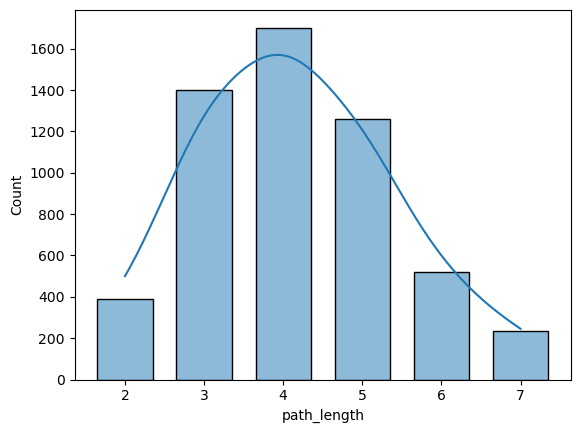

In [19]:
sns.histplot(data=filtered_paths_df, x="path_length",bins=35,stat = 'count',discrete= True, shrink=0.7,
  multiple="dodge", palette="flare", kde=True, kde_kws={'bw_method': 0.5})

<AxesSubplot: xlabel='path_length', ylabel='position_mean'>

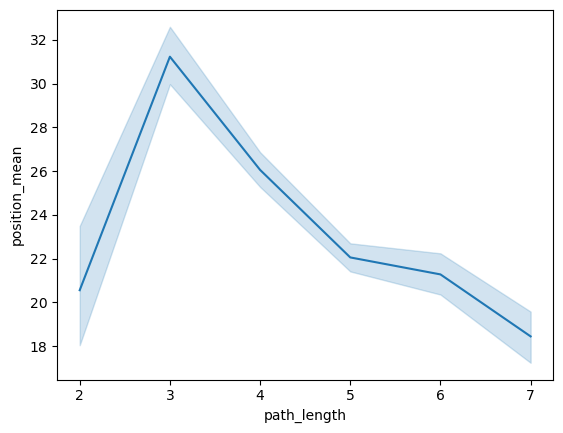

In [20]:
# plot average position_mean for each path length with line
sns.lineplot(data=filtered_paths_df, x="path_length", y="position_mean", palette="flare",)
#sns.barplot(x="path_length", y="position_mean", data=filtered_paths_df, palette="flare",)



<AxesSubplot: xlabel='path_length', ylabel='relative_mean'>

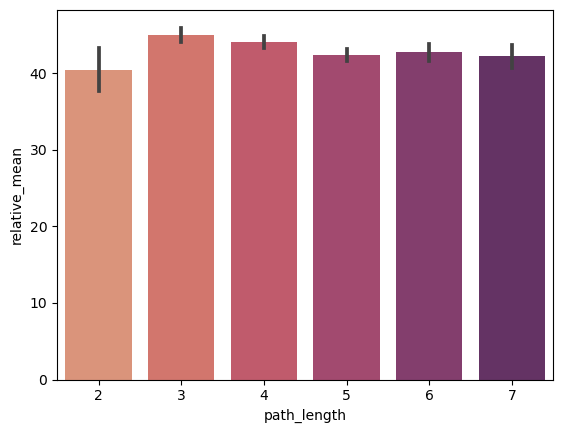

In [21]:
# plot average relative_mean for each path length
sns.barplot(x="path_length", y="relative_mean", data=filtered_paths_df, palette="flare")


<AxesSubplot: xlabel='path_length', ylabel='position_mean'>

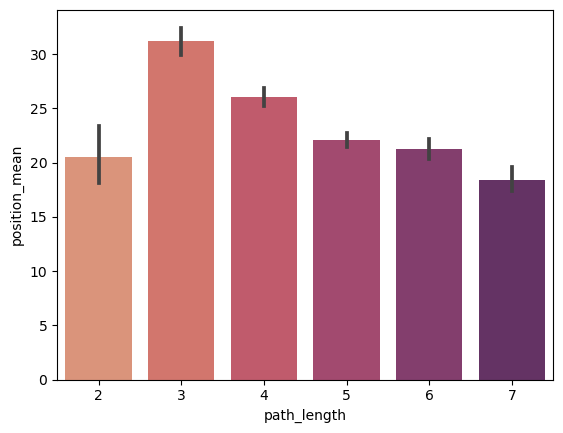

In [22]:
sns.barplot(x="path_length", y="position_mean", data=filtered_paths_df, palette="flare")


In [23]:

paths_df = pd.read_pickle('data/df_paths_finished.pkl')

In [24]:
paths_df

,path,start,end,length
0,"[14th_century, 15th_century, 16th_century, Pac...",14th_century,African_slave_trade,9
1,"[14th_century, Europe, Africa, Atlantic_slave_...",14th_century,African_slave_trade,5
2,"[14th_century, Niger, Nigeria, British_Empire,...",14th_century,African_slave_trade,8
3,"[14th_century, Renaissance, Ancient_Greece, Gr...",14th_century,Greece,4
4,"[14th_century, Italy, Roman_Catholic_Church, H...",14th_century,John_F._Kennedy,7
...,...,...,...,...
42261,"[Work_%28thermodynamics%29, Energy, Aristotle,...",Work_%28thermodynamics%29,Film,13
42262,"[Yagan, Ancient_Egypt, Civilization]",Yagan,Civilization,3
42263,"[Yagan, Australia, England, France, United_Sta...",Yagan,U.S._Open_%28tennis%29,7
42264,"[Yarralumla%2C_Australian_Capital_Territory, A...",Yarralumla%2C_Australian_Capital_Territory,Abraham_Lincoln,4


In [25]:
def get_link_positions(path,groups) : 

    positions = []
    for i in range(0,len(path)-1):
        try:
            temp_df = groups.get_group((path[i],path[i+1]))
        except Exception as e:
         
            positions.append(np.nan)
            continue
        positions.append(temp_df['position'].item())
        
    return positions

In [26]:
def get_link_relative_positions(path,groups) : 

    positions = []
    for i in range(0,len(path)-1):
        try:
            temp_df = groups.get_group((path[i],path[i+1]))
        except Exception as e:
         
            positions.append(np.nan)
            continue
        positions.append(temp_df['relative_position'].item())
        
    return positions

In [27]:
groups = links_df.groupby(['article_from','article_to'])
paths_df['positions'] = paths_df['path'].apply(lambda x: get_link_positions(x,groups)) 
paths_df['relative_postions'] = paths_df['path'].apply(lambda x: get_link_relative_positions(x,groups))

In [28]:
paths_df

,path,start,end,length,positions,relative_postions
0,"[14th_century, 15th_century, 16th_century, Pac...",14th_century,African_slave_trade,9,"[1, nan, 60, nan, 89, 10, nan, 13]","[3.0, nan, 66.0, nan, 71.0, 77.0, nan, 22.0]"
1,"[14th_century, Europe, Africa, Atlantic_slave_...",14th_century,African_slave_trade,5,"[nan, nan, nan, 13]","[nan, nan, nan, 22.0]"
2,"[14th_century, Niger, Nigeria, British_Empire,...",14th_century,African_slave_trade,8,"[20, nan, nan, nan, nan, nan, 13]","[65.0, nan, nan, nan, nan, nan, 22.0]"
3,"[14th_century, Renaissance, Ancient_Greece, Gr...",14th_century,Greece,4,"[nan, 21, nan]","[nan, 33.0, nan]"
4,"[14th_century, Italy, Roman_Catholic_Church, H...",14th_century,John_F._Kennedy,7,"[5, 16, 52, 6, nan, nan]","[16.0, 19.0, 95.0, 38.0, nan, nan]"
...,...,...,...,...,...,...
42261,"[Work_%28thermodynamics%29, Energy, Aristotle,...",Work_%28thermodynamics%29,Film,13,"[nan, 1, nan, 18, 4, 26, 4, nan, nan, nan, 16, 0]","[nan, 2.0, nan, 46.0, 4.0, 68.0, 22.0, nan, na..."
42262,"[Yagan, Ancient_Egypt, Civilization]",Yagan,Civilization,3,"[12, 0]","[63.0, 0.0]"
42263,"[Yagan, Australia, England, France, United_Sta...",Yagan,U.S._Open_%28tennis%29,7,"[2, 27, nan, nan, 159, nan]","[11.0, 31.0, nan, nan, 54.0, nan]"
42264,"[Yarralumla%2C_Australian_Capital_Territory, A...",Yarralumla%2C_Australian_Capital_Territory,Abraham_Lincoln,4,"[nan, nan, 51]","[nan, nan, 17.0]"


In [29]:
# remove paths with nan values
paths_df['contains_rep'] =  paths_df['positions'].apply(lambda x: check_nan(x))

In [30]:
# print len paths with contains_rep = True
print(len(paths_df[paths_df['contains_rep'] == True]))

37467


In [31]:
# filter paths with contains_rep = True
paths_df = paths_df[paths_df['contains_rep'] == False]
len(paths_df)

4799

In [32]:
# drop contains_rep column
paths_df = paths_df.drop(columns=['contains_rep'])

In [33]:
paths_df['mean'] = paths_df['positions'].apply(lambda x: np.mean(x))
paths_df['relative_mean'] = paths_df['relative_postions'].apply(lambda x: np.mean(x))


In [34]:
paths_df

,path,start,end,length,positions,relative_postions,mean,relative_mean
8,"[14th_century, Time, Light, Rainbow]",14th_century,Rainbow,4,"[3, 34, 13]","[10.0, 81.0, 24.0]",16.666667,38.333333
9,"[14th_century, 15th_century, Plato, Nature, Ul...",14th_century,Rainbow,7,"[1, 27, 24, 28, 2, 6]","[3.0, 47.0, 55.00000000000001, 41.0, 6.0, 32.0]",14.666667,30.666667
11,"[14th_century, Time, Astronomy, Light, Rainbow]",14th_century,Rainbow,5,"[3, 10, 42, 13]","[10.0, 24.0, 56.00000000000001, 24.0]",17.000000,28.500000
16,"[14th_century, Christianity, Religion, Astrolo...",14th_century,Rainbow,7,"[16, 0, 41, 10, 9, 6]","[52.0, 0.0, 87.0, 21.0, 16.0, 32.0]",13.666667,34.666667
17,"[14th_century, Time, Light, Rainbow]",14th_century,Rainbow,4,"[3, 34, 13]","[10.0, 81.0, 24.0]",16.666667,38.333333
...,...,...,...,...,...,...,...,...
42233,"[Timken_1111, Pennsylvania_Railroad, Gold_stan...",Timken_1111,List_of_elements_by_name,6,"[0, 4, 1, 13, 11]","[0.0, 28.999999999999996, 2.0, 15.0, 32.0]",5.800000,15.600000
42234,"[Timken_1111, Chicago, Roman_Catholic_Church, ...",Timken_1111,British_monarchy,6,"[1, 28, 22, 11, 19]","[33.0, 82.0, 40.0, 18.0, 36.0]",16.200000,41.800000
42253,"[War_in_Somalia_%282006%E2%80%93present%29, BB...",War_in_Somalia_%282006%E2%80%93present%29,Auto_racing,4,"[5, 31, 158]","[36.0, 78.0, 54.0]",64.666667,56.000000
42260,"[Women%27s_rights, Property, Clothing, Weather...",Women%27s_rights,Autumn,5,"[4, 24, 0, 2]","[17.0, 73.0, 0.0, 5.0]",7.500000,23.750000


In [35]:
# drop paths with length > 8
paths_df = paths_df[paths_df['length'] < 8]

<AxesSubplot: xlabel='length', ylabel='relative_mean'>

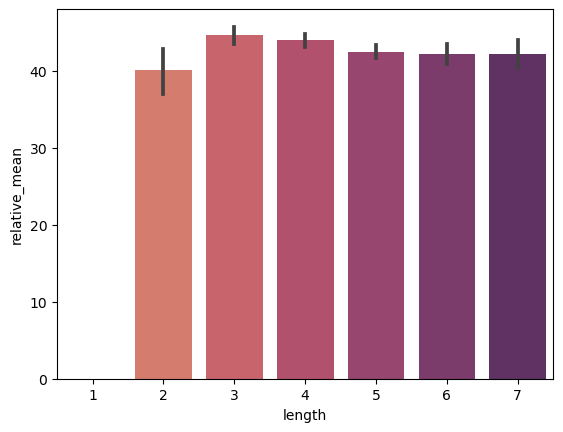

In [36]:
sns.barplot(x="length", y="relative_mean", data=paths_df, palette="flare" )

In [37]:
# groupby start and end node
groups = paths_df.groupby(['start','end']).size().reset_index(name='counts')


In [38]:
groups.sort_values(by=['counts'],ascending=False)

,start,end,counts
2832,Pyramid,Bean,88
319,Asteroid,Viking,64
444,Batman,Wood,53
612,Brain,Telephone,43
3426,Theatre,Zebra,36
...,...,...,...
1341,Fatty_acid,Pythagorean_theorem,1
1342,Fauna_of_Australia,Goa,1
1344,Feather,Crusades,1
1345,Feather,Palladium,1


In [39]:
# number of games with count > 20
len(groups[groups['counts'] > 10])


10

In [40]:
# keep only paths with count > 20
groups = groups[groups['counts'] > 10]
groups.reset_index(drop=True, inplace=True)

In [41]:
groups.reset_index(inplace=True)

In [42]:
groups

,index,start,end,counts
0,0,Asteroid,Viking,64
1,1,Batman,Japan,12
2,2,Batman,Wood,53
3,3,Beer,Sun,32
4,4,Bird,Great_white_shark,29
5,5,Brain,Telephone,43
6,6,Dog,Telephone,11
7,7,Jesus,God,27
8,8,Pyramid,Bean,88
9,9,Theatre,Zebra,36


In [43]:
#get game of path
def get_game(start,end,groups):
    res = groups[(groups['start'] == start) & (groups['end'] == end)]
    if len(res) > 0 : 
        return res['index'].item()
    else :
        return np.nan

In [44]:
# assgin a game number to each path
paths_df['game'] = paths_df.apply(lambda row: get_game(row['start'],row['end'],groups) ,axis=1)





In [45]:
paths_df

,path,start,end,length,positions,relative_postions,mean,relative_mean,game
8,"[14th_century, Time, Light, Rainbow]",14th_century,Rainbow,4,"[3, 34, 13]","[10.0, 81.0, 24.0]",16.666667,38.333333,NaN
9,"[14th_century, 15th_century, Plato, Nature, Ul...",14th_century,Rainbow,7,"[1, 27, 24, 28, 2, 6]","[3.0, 47.0, 55.00000000000001, 41.0, 6.0, 32.0]",14.666667,30.666667,NaN
11,"[14th_century, Time, Astronomy, Light, Rainbow]",14th_century,Rainbow,5,"[3, 10, 42, 13]","[10.0, 24.0, 56.00000000000001, 24.0]",17.000000,28.500000,NaN
16,"[14th_century, Christianity, Religion, Astrolo...",14th_century,Rainbow,7,"[16, 0, 41, 10, 9, 6]","[52.0, 0.0, 87.0, 21.0, 16.0, 32.0]",13.666667,34.666667,NaN
17,"[14th_century, Time, Light, Rainbow]",14th_century,Rainbow,4,"[3, 34, 13]","[10.0, 81.0, 24.0]",16.666667,38.333333,NaN
...,...,...,...,...,...,...,...,...,...
42233,"[Timken_1111, Pennsylvania_Railroad, Gold_stan...",Timken_1111,List_of_elements_by_name,6,"[0, 4, 1, 13, 11]","[0.0, 28.999999999999996, 2.0, 15.0, 32.0]",5.800000,15.600000,NaN
42234,"[Timken_1111, Chicago, Roman_Catholic_Church, ...",Timken_1111,British_monarchy,6,"[1, 28, 22, 11, 19]","[33.0, 82.0, 40.0, 18.0, 36.0]",16.200000,41.800000,NaN
42253,"[War_in_Somalia_%282006%E2%80%93present%29, BB...",War_in_Somalia_%282006%E2%80%93present%29,Auto_racing,4,"[5, 31, 158]","[36.0, 78.0, 54.0]",64.666667,56.000000,NaN
42260,"[Women%27s_rights, Property, Clothing, Weather...",Women%27s_rights,Autumn,5,"[4, 24, 0, 2]","[17.0, 73.0, 0.0, 5.0]",7.500000,23.750000,NaN


In [46]:
len(paths_df[paths_df['game'].isna()])

4287

In [47]:
games = paths_df[paths_df['game'].notna()]

In [48]:
games

,path,start,end,length,positions,relative_postions,mean,relative_mean,game
1136,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
1137,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
1140,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
1141,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
1143,"[Batman, Scotland, United_Nations, Japan]",Batman,Japan,4,"[1, 29, 37]","[17.0, 26.0, 33.0]",22.333333,25.333333,1.0
...,...,...,...,...,...,...,...,...,...
40475,"[Theatre, Aristotle, Biology, Lion, Zebra]",Theatre,Zebra,5,"[4, 8, 37, 25]","[24.0, 22.0, 71.0, 61.0]",18.500000,44.500000,9.0
40478,"[Theatre, Paris, Africa, Lion, Zebra]",Theatre,Zebra,5,"[8, 28, 25, 25]","[47.0, 25.0, 12.0, 61.0]",21.500000,36.250000,9.0
40484,"[Theatre, Aristotle, Biology, Scientific_class...",Theatre,Zebra,6,"[4, 8, 1, 22, 41]","[24.0, 22.0, 2.0, 88.0, 98.0]",15.200000,46.800000,9.0
40500,"[Theatre, Aristotle, Biology, Lion, Zebra]",Theatre,Zebra,5,"[4, 8, 37, 25]","[24.0, 22.0, 71.0, 61.0]",18.500000,44.500000,9.0


**Game 1**

In [49]:
game_1 = games[games['game'] == 8]

In [50]:
len(game_1)

88

In [51]:
game_1

,path,start,end,length,positions,relative_postions,mean,relative_mean,game
16845,"[Pyramid, Earth, Plant, Seed, Bean]",Pyramid,Bean,5,"[0, 66, 20, 3]","[0.0, 56.00000000000001, 28.999999999999996, 1...",22.250000,23.750000,8.0
16846,"[Pyramid, Mexico_City, Mestizo, Aztec, Maize, ...",Pyramid,Bean,7,"[7, 7, 31, 14, 12, 4]","[41.0, 19.0, 53.0, 78.0, 24.0, 15.0]",12.500000,38.333333,8.0
16853,"[Pyramid, Mesopotamia, Barley, Plant, Fruit, B...",Pyramid,Bean,6,"[5, 39, 1, 61, 21]","[28.999999999999996, 65.0, 4.0, 87.0, 51.0]",25.400000,47.200000,8.0
16855,"[Pyramid, Sun, Vitamin_D, Vitamin, Rice, Seed,...",Pyramid,Bean,7,"[4, 32, 2, 13, 8, 3]","[24.0, 43.0, 15.0, 48.0, 8.0, 10.0]",10.333333,24.666667,8.0
16856,"[Pyramid, Earth, Plant, Seed, Bean]",Pyramid,Bean,5,"[0, 66, 20, 3]","[0.0, 56.00000000000001, 28.999999999999996, 1...",22.250000,23.750000,8.0
...,...,...,...,...,...,...,...,...,...
17307,"[Pyramid, Mexico, Wine, Fruit, Bean]",Pyramid,Bean,5,"[6, 52, 0, 21]","[35.0, 78.0, 0.0, 51.0]",19.750000,41.000000,8.0
17313,"[Pyramid, France, Currency, Ecuador, Soup, Bean]",Pyramid,Bean,6,"[11, 4, 10, 37, 36]","[65.0, 5.0, 45.0, 88.0, 63.0]",19.600000,53.200000,8.0
17321,"[Pyramid, Mesopotamia, Barley, Bran, Cereal, B...",Pyramid,Bean,7,"[5, 39, 25, 0, 29, 20]","[28.999999999999996, 65.0, 96.0, 0.0, 76.0, 31.0]",19.666667,49.500000,8.0
17323,"[Pyramid, Earth, Plant, Seed, Bean]",Pyramid,Bean,5,"[0, 66, 20, 3]","[0.0, 56.00000000000001, 28.999999999999996, 1...",22.250000,23.750000,8.0


In [52]:
import statsmodels.formula.api as smf

In [53]:
# Parametrize the model 
mod = smf.ols(formula='length ~   relative_mean', data=game_1)
# Fit the model
res = mod.fit()
# Print the summary of the model
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     26.22
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           1.84e-06
Time:                        16:12:28   Log-Likelihood:                -100.55
No. Observations:                  88   AIC:                             205.1
Df Residuals:                      86   BIC:                             210.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.7057      0.277     24.236

<AxesSubplot: xlabel='length', ylabel='relative_mean'>

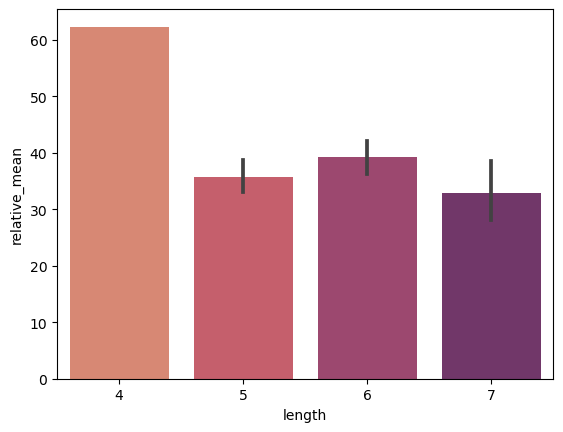

In [54]:
# plot average relative_mean for each path length # with line   
sns.barplot(x="length", y="relative_mean", data=game_1, palette="flare" )

In [55]:
# remove paths with length 1
paths_df = paths_df[paths_df['length'] > 1]

In [56]:
game_1.reset_index(drop=True, inplace=True)

In [57]:
game_1

,path,start,end,length,positions,relative_postions,mean,relative_mean,game
0,"[Pyramid, Earth, Plant, Seed, Bean]",Pyramid,Bean,5,"[0, 66, 20, 3]","[0.0, 56.00000000000001, 28.999999999999996, 1...",22.250000,23.750000,8.0
1,"[Pyramid, Mexico_City, Mestizo, Aztec, Maize, ...",Pyramid,Bean,7,"[7, 7, 31, 14, 12, 4]","[41.0, 19.0, 53.0, 78.0, 24.0, 15.0]",12.500000,38.333333,8.0
2,"[Pyramid, Mesopotamia, Barley, Plant, Fruit, B...",Pyramid,Bean,6,"[5, 39, 1, 61, 21]","[28.999999999999996, 65.0, 4.0, 87.0, 51.0]",25.400000,47.200000,8.0
3,"[Pyramid, Sun, Vitamin_D, Vitamin, Rice, Seed,...",Pyramid,Bean,7,"[4, 32, 2, 13, 8, 3]","[24.0, 43.0, 15.0, 48.0, 8.0, 10.0]",10.333333,24.666667,8.0
4,"[Pyramid, Earth, Plant, Seed, Bean]",Pyramid,Bean,5,"[0, 66, 20, 3]","[0.0, 56.00000000000001, 28.999999999999996, 1...",22.250000,23.750000,8.0
...,...,...,...,...,...,...,...,...,...
83,"[Pyramid, Mexico, Wine, Fruit, Bean]",Pyramid,Bean,5,"[6, 52, 0, 21]","[35.0, 78.0, 0.0, 51.0]",19.750000,41.000000,8.0
84,"[Pyramid, France, Currency, Ecuador, Soup, Bean]",Pyramid,Bean,6,"[11, 4, 10, 37, 36]","[65.0, 5.0, 45.0, 88.0, 63.0]",19.600000,53.200000,8.0
85,"[Pyramid, Mesopotamia, Barley, Bran, Cereal, B...",Pyramid,Bean,7,"[5, 39, 25, 0, 29, 20]","[28.999999999999996, 65.0, 96.0, 0.0, 76.0, 31.0]",19.666667,49.500000,8.0
86,"[Pyramid, Earth, Plant, Seed, Bean]",Pyramid,Bean,5,"[0, 66, 20, 3]","[0.0, 56.00000000000001, 28.999999999999996, 1...",22.250000,23.750000,8.0


In [58]:
# create all posible pairs of paths

def get_pairs(df):

    pairs_dict = {}
    pairs = []
    counter = 0 
    for i in range(0,len(df)):
        for j in range(0,len(df)):
            if i != j:
                game1 = df.iloc[i]
                game2 = df.iloc[j]
                # if not the same game continue
                if game1['game'] != game2['game']:
                    continue
                pairs_dict[counter] = {'game':game1['game'],'start':game1['start'],'end':game1['end'],'length1':game1['length'],'length2':game2['length'],'mean1':game1['mean'],'mean2':game2['mean'],'mean_diff':game1['mean'] - game2['mean'],'winner': 0 if game2['length'] < game1['length'] else 1}
                counter += 1
    #dict to df 
    pairs_df = pd.DataFrame.from_dict(pairs_dict, orient='index')
    return pairs_df

    

In [59]:
paths_df.reset_index(drop=True, inplace=True)

In [60]:
# drop paths with ni game
paths_df = paths_df[paths_df['game'].notna()]

In [61]:
#remove warnings
import warnings
warnings.filterwarnings('ignore')

In [62]:
pairs_df = get_pairs(paths_df)

In [63]:
# drop poaris with same length
pairs_df = pairs_df[pairs_df['length1'] != pairs_df['length2']]

In [64]:
pairs_df

,game,start,end,length1,length2,mean1,mean2,mean_diff,winner
3,1.0,Batman,Japan,3,4,10.0,22.333333,-12.333333,1
4,1.0,Batman,Japan,3,4,10.0,13.000000,-3.000000,1
7,1.0,Batman,Japan,3,5,10.0,41.750000,-31.750000,1
10,1.0,Batman,Japan,3,4,10.0,22.333333,-12.333333,1
14,1.0,Batman,Japan,3,4,10.0,22.333333,-12.333333,1
...,...,...,...,...,...,...,...,...,...
20253,9.0,Theatre,Zebra,7,5,17.5,18.500000,-1.000000,0
20254,9.0,Theatre,Zebra,7,5,17.5,18.500000,-1.000000,0
20255,9.0,Theatre,Zebra,7,5,17.5,21.500000,-4.000000,0
20256,9.0,Theatre,Zebra,7,6,17.5,15.200000,2.300000,0


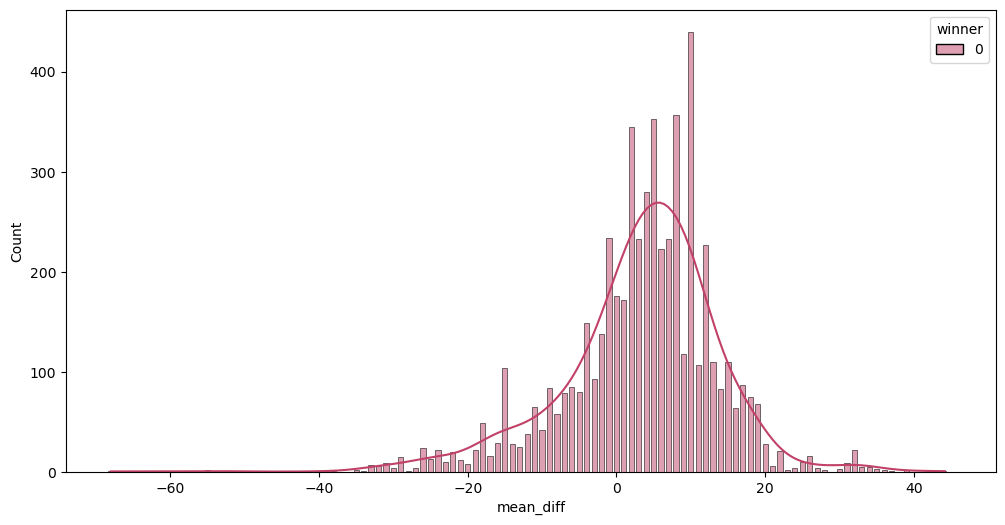

In [94]:
sns.histplot(data=pairs_df, x="mean_diff", hue="winner",bins=35,stat = 'count',discrete= True, shrink=0.7,
  multiple="dodge", palette="flare", kde=True, kde_kws={'bw_method': 0.28})
#make the plot bigger
plt.rcParams['figure.figsize'] = [12, 6]

<AxesSubplot: xlabel='winner', ylabel='mean_diff'>

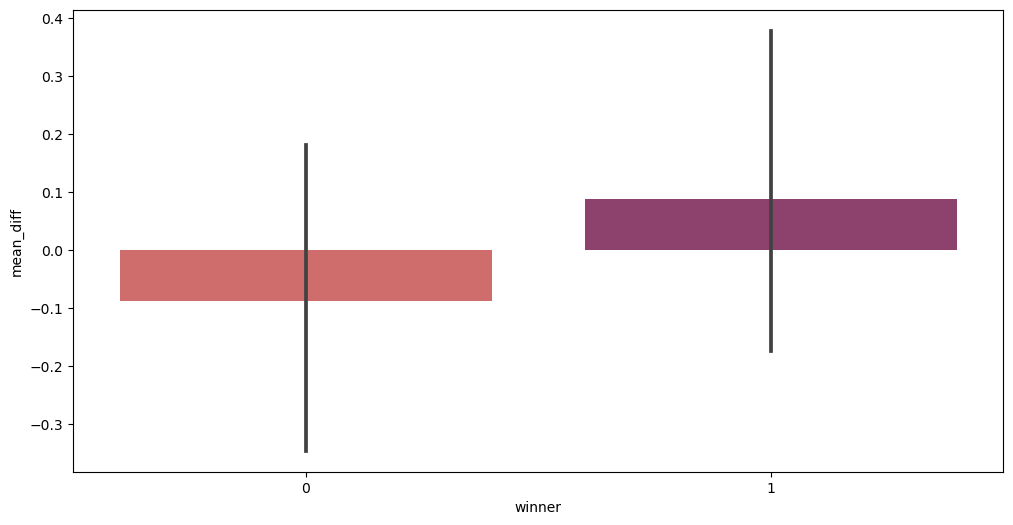

In [66]:
# plot relative_mean_diff against winner
sns.barplot(x="winner", y="mean_diff", data=pairs_df, palette="flare" )

# Unfinished games analysis

In [67]:
df_paths_unfinished = pd.DataFrame(columns=['path', 'start', 'end', 'length', 'stop_reason'])
counter = 0

with open("data/paths_unfinished.tsv",encoding="utf8") as file:
            tsv_file = csv.reader(file, delimiter="\t")
            for line in tsv_file:
                # Skip empty or commented lines 
                if len(line)==0 or line[0].startswith("#"):
                    continue
                else:   
                    path = line[3].split(';')
                  
                    if path.__contains__('<') or path.__contains__('Pikachu'):
                        continue

                    end = line[4]
                    reason = line[5]
                    start = path[0]
                    length = len(path)
                    df_paths_unfinished.loc[counter] = [path, start, end, length, reason]
                    counter += 1

In [68]:
len(df_paths_unfinished)


19657

In [69]:
groups = links_df.groupby(['article_from','article_to'])
df_paths_unfinished['positions'] = df_paths_unfinished['path'].apply(lambda x: get_link_positions(x,groups)) 
df_paths_unfinished['relative_postions'] = df_paths_unfinished['path'].apply(lambda x: get_link_relative_positions(x,groups))

In [70]:
df_paths_unfinished['mean'] = df_paths_unfinished['positions'].apply(lambda x: np.mean(x))
df_paths_unfinished['relative_mean'] = df_paths_unfinished['relative_postions'].apply(lambda x: np.mean(x))


In [71]:
# drop paths with length <2
df_paths_unfinished = df_paths_unfinished[df_paths_unfinished['length'] > 1]
len(df_paths_unfinished)

14449

In [72]:
df_paths_unfinished

,path,start,end,length,stop_reason,positions,relative_postions,mean,relative_mean
2,"[Malawi, Democracy, Alexander_the_Great]",Malawi,First_Crusade,3,timeout,"[3, 8]","[3.0, 18.0]",5.50,10.5
4,"[Paraguay, Bolivia]",Paraguay,Mount_St._Helens,2,timeout,[9],[45.0],9.00,45.0
5,"[Agriculture, History_of_the_world, China, Yan...",Agriculture,Grand_Canal_of_China,4,timeout,"[1, nan, nan]","[2.0, nan, nan]",NaN,NaN
6,"[Mind, Christianity, Europe, Renaissance, Anci...",Mind,Scouting,7,timeout,"[6, 2, nan, 21, 48, nan]","[40.0, 4.0, nan, 33.0, 74.0, nan]",NaN,NaN
7,"[4-2-0, United_States, Agriculture, Sugar, Aus...",4-2-0,Cane_Toad,5,restart,"[1, nan, 10, 16]","[25.0, nan, 18.0, 30.0]",NaN,NaN
...,...,...,...,...,...,...,...,...,...
19651,"[Montenegro, World_War_II, United_States, Cari...",Montenegro,Hurricane_Georges,7,restart,"[22, nan, nan, 19, 65, 1]","[25.0, nan, nan, 90.0, 77.0, 2.0]",NaN,NaN
19652,"[Wine, Georgia_%28country%29, Russia]",Wine,History_of_post-Soviet_Russia,3,restart,"[nan, nan]","[nan, nan]",NaN,NaN
19653,"[Turks_and_Caicos_Islands, United_States, Iraq...",Turks_and_Caicos_Islands,Iraq_War,6,restart,"[nan, 67, nan, 108, 2]","[nan, 23.0, nan, 96.0, 7.000000000000001]",NaN,NaN
19655,"[Jamaica, United_Kingdom, World_War_II, Battle...",Jamaica,Alan_Turing,4,timeout,"[nan, 44, nan]","[nan, 26.0, nan]",NaN,NaN


In [73]:
df_paths_unfinished['contains_nan'] = df_paths_unfinished.apply(lambda row: check_nan(row['positions']),axis=1)
df_paths_unfinished = df_paths_unfinished[~ df_paths_unfinished['contains_nan']]
# drop contains_nan column
df_paths_unfinished.drop(columns=['contains_nan'], inplace=True)

In [74]:
len(df_paths_unfinished)

3572

In [75]:
df_paths_unfinished.groupby(['stop_reason']).count()

,path,start,end,length,positions,relative_postions,mean,relative_mean
stop_reason,,,,,,,,
restart,2060,2060,2060,2060,2060,2060,2060,2060
timeout,1512,1512,1512,1512,1512,1512,1512,1512


In [76]:
# discarding timeout paths
df_paths_unfinished = df_paths_unfinished[df_paths_unfinished['stop_reason'] != 'timeout']
len(df_paths_unfinished)

2060

In [77]:
df_paths_unfinished.describe()

,length,mean,relative_mean
count,2060.000000,2060.000000,2060.000000
mean,2.873301,15.272183,40.717492
std,1.242350,15.014509,23.732178
min,2.000000,0.000000,0.000000
25%,2.000000,5.000000,22.937500
50%,2.000000,11.500000,40.000000
75%,3.000000,21.000000,56.500000
max,11.000000,186.000000,99.000000


<AxesSubplot: xlabel='length', ylabel='relative_mean'>

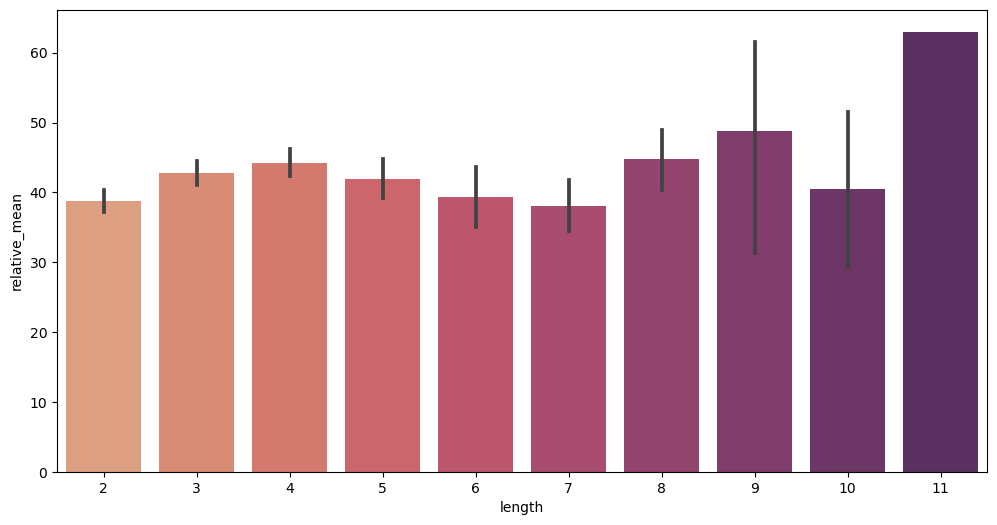

In [78]:
# plot average relative_mean for each path length # with line
sns.barplot(x="length", y="relative_mean", data=df_paths_unfinished, palette="flare" )

In [79]:
df_paths_unfinished

,path,start,end,length,stop_reason,positions,relative_postions,mean,relative_mean
14,"[Symmetry, Science, Age_of_Enlightenment, Dark...",Symmetry,Scottish_Episcopal_Church,6,restart,"[4, 7, 6, 5, 82]","[8.0, 17.0, 11.0, 21.0, 49.0]",20.800000,21.2
16,"[Tasmanian_Devil, Dog, Postage_stamp, Wood]",Tasmanian_Devil,Love,4,restart,"[7, 11, 5]","[57.99999999999999, 28.000000000000004, 28.000...",7.666667,38.0
39,"[The_Fairy-Queen, London, British_House_of_Com...",The_Fairy-Queen,Parliamentary_system,5,restart,"[1, 53, 0, 28]","[11.0, 52.0, 0.0, 55.00000000000001]",20.500000,29.5
54,"[Perfect_number, Euclid, Greece]",Perfect_number,Mark_Twain_House,3,restart,"[2, 2]","[50.0, 18.0]",2.000000,34.0
72,"[President_of_the_United_States, Boeing_747, C...",President_of_the_United_States,Force,4,restart,"[19, 5, 25]","[33.0, 14.000000000000002, 57.99999999999999]",16.333333,35.0
...,...,...,...,...,...,...,...,...,...
19631,"[13th_century, Time]",13th_century,Climate_change,2,restart,[2],[6.0],2.000000,6.0
19637,"[Libertarianism, Property, Economics]",Libertarianism,AK-47,3,restart,"[2, 1]","[8.0, 3.0]",1.500000,5.5
19645,"[Odyssey, Epic_of_Gilgamesh]",Odyssey,Husein_Grada%C5%A1%C4%8Devi%C4%87,2,restart,[13],[93.0],13.000000,93.0
19648,"[Asteroid, Carl_Friedrich_Gauss]",Asteroid,Viking,2,restart,[9],[47.0],9.000000,47.0


In [80]:
paths_df

,path,start,end,length,positions,relative_postions,mean,relative_mean,game
116,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
117,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
118,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
119,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
120,"[Batman, Scotland, United_Nations, Japan]",Batman,Japan,4,"[1, 29, 37]","[17.0, 26.0, 33.0]",22.333333,25.333333,1.0
...,...,...,...,...,...,...,...,...,...
4493,"[Theatre, Aristotle, Biology, Lion, Zebra]",Theatre,Zebra,5,"[4, 8, 37, 25]","[24.0, 22.0, 71.0, 61.0]",18.500000,44.500000,9.0
4494,"[Theatre, Paris, Africa, Lion, Zebra]",Theatre,Zebra,5,"[8, 28, 25, 25]","[47.0, 25.0, 12.0, 61.0]",21.500000,36.250000,9.0
4495,"[Theatre, Aristotle, Biology, Scientific_class...",Theatre,Zebra,6,"[4, 8, 1, 22, 41]","[24.0, 22.0, 2.0, 88.0, 98.0]",15.200000,46.800000,9.0
4496,"[Theatre, Aristotle, Biology, Lion, Zebra]",Theatre,Zebra,5,"[4, 8, 37, 25]","[24.0, 22.0, 71.0, 61.0]",18.500000,44.500000,9.0


In [81]:
groups = paths_df.groupby(['start','end']).size().reset_index(name='counts')


In [82]:
groups.reset_index(inplace=True)

In [83]:
# get game of each path of unfinished paths
df_paths_unfinished['game'] = df_paths_unfinished.apply(lambda row: get_game(row['start'],row['end'],groups),axis=1)

In [84]:
paths_df

,path,start,end,length,positions,relative_postions,mean,relative_mean,game
116,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
117,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
118,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
119,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
120,"[Batman, Scotland, United_Nations, Japan]",Batman,Japan,4,"[1, 29, 37]","[17.0, 26.0, 33.0]",22.333333,25.333333,1.0
...,...,...,...,...,...,...,...,...,...
4493,"[Theatre, Aristotle, Biology, Lion, Zebra]",Theatre,Zebra,5,"[4, 8, 37, 25]","[24.0, 22.0, 71.0, 61.0]",18.500000,44.500000,9.0
4494,"[Theatre, Paris, Africa, Lion, Zebra]",Theatre,Zebra,5,"[8, 28, 25, 25]","[47.0, 25.0, 12.0, 61.0]",21.500000,36.250000,9.0
4495,"[Theatre, Aristotle, Biology, Scientific_class...",Theatre,Zebra,6,"[4, 8, 1, 22, 41]","[24.0, 22.0, 2.0, 88.0, 98.0]",15.200000,46.800000,9.0
4496,"[Theatre, Aristotle, Biology, Lion, Zebra]",Theatre,Zebra,5,"[4, 8, 37, 25]","[24.0, 22.0, 71.0, 61.0]",18.500000,44.500000,9.0


In [85]:
# drop paths with ni game
df_paths_unfinished = df_paths_unfinished[df_paths_unfinished['game'].notna()]
len(df_paths_unfinished)

332

In [86]:
paths_df['stop_reason'] = 'finished'

In [87]:
# add winner column for finished paths
paths_df['winner'] = 1
df_paths_unfinished['winner'] = 0


In [88]:
# concat finished and unfinished paths
paths_df = pd.concat([paths_df, df_paths_unfinished], ignore_index=True)

In [89]:
len(paths_df)

727

In [90]:
# drop paths with length < 4
paths_df = paths_df[paths_df['length'] > 3]
len(paths_df)

415

In [91]:
paths_df.reset_index(drop=True, inplace=True)

In [106]:
losers = paths_df[paths_df['winner'] == 0].reset_index(drop=True)
winners = paths_df[paths_df['winner'] == 1].reset_index(drop=True)

# print len of winners and losers
print(len(winners))
print(len(losers))





335
80


In [119]:
winners.reset_index(drop=True, inplace=True)

In [120]:

pairs_dict = {}
pairs = []
counter = 0 
for i in range(0,len(losers)):
    loser = losers.iloc[i]
    for j in range(0,len(winners)):
        winner = winners.iloc[j]
        if loser['game'] == winner['game'] : 
            pairs_dict[counter] = {'game':loser['game'],'start':loser['start'],'end':loser['end'],'length_loser':loser['length'],'length_winner':winner['length'],'mean_loser':loser['mean'],'mean_winner':winner['mean'],'mean_diff':loser['mean'] - winner['mean']}
            counter += 1
            # remove winner from winners
            winners = winners.drop([j]).reset_index(drop=True)
            break

#dict to df
pairs_df = pd.DataFrame.from_dict(pairs_dict, orient='index')
            





In [121]:
len(pairs_df)

80

In [122]:
pairs_df

,game,start,end,length_loser,length_winner,mean_loser,mean_winner,mean_diff
0,8.0,Pyramid,Bean,5,7,27.000000,12.500000,14.500000
1,8.0,Pyramid,Bean,4,6,22.000000,25.400000,-3.400000
2,8.0,Pyramid,Bean,5,7,21.250000,10.333333,10.916667
3,8.0,Pyramid,Bean,5,5,26.250000,22.250000,4.000000
4,8.0,Pyramid,Bean,4,5,24.666667,15.000000,9.666667
...,...,...,...,...,...,...,...,...
75,0.0,Asteroid,Viking,4,5,20.333333,36.500000,-16.166667
76,8.0,Pyramid,Bean,4,7,24.666667,25.166667,-0.500000
77,8.0,Pyramid,Bean,4,5,24.666667,15.000000,9.666667
78,8.0,Pyramid,Bean,4,5,32.333333,19.250000,13.083333


In [125]:
# mean diff for each game
pairs_df.groupby(['game']).mean()


,length_loser,length_winner,mean_loser,mean_winner,mean_diff
game,,,,,
0.0,5.142857,5.142857,20.540476,27.250000,-6.709524
2.0,4.750000,5.000000,14.308333,24.312500,-10.004167
3.0,5.500000,4.500000,16.675000,15.541667,1.133333
4.0,4.000000,5.000000,7.333333,11.500000,-4.166667
5.0,4.600000,5.400000,19.453333,20.363333,-0.910000
8.0,4.510638,5.319149,23.981510,18.736170,5.245339
9.0,4.111111,6.000000,15.888889,21.031481,-5.142593


<AxesSubplot: xlabel='winner', ylabel='relative_mean'>

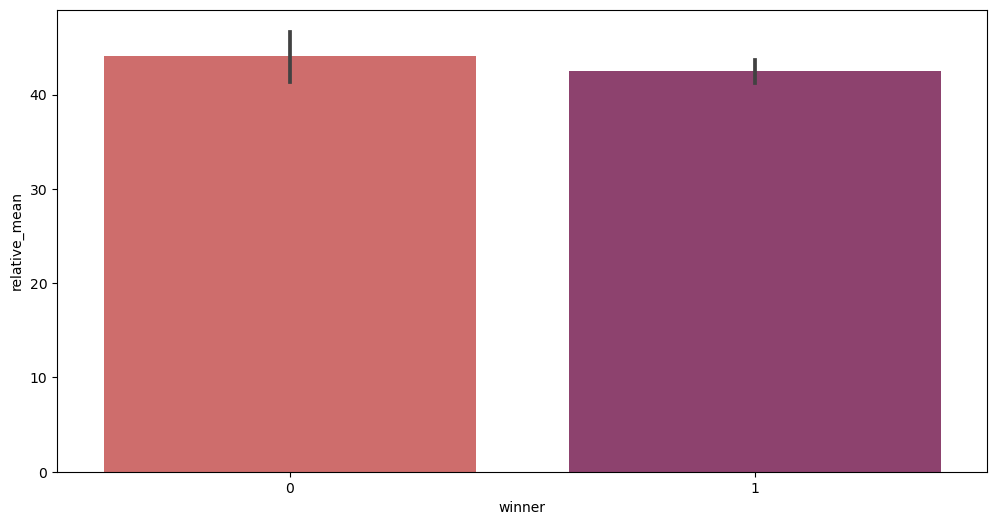

In [129]:

# plot relative_postion for winner and loser
sns.barplot(x="winner", y="relative_mean", data=paths_df, palette="flare" )

In [128]:
paths_df

,path,start,end,length,positions,relative_postions,mean,relative_mean,game,stop_reason,winner
0,"[Batman, Scotland, United_Nations, Japan]",Batman,Japan,4,"[1, 29, 37]","[17.0, 26.0, 33.0]",22.333333,25.333333,1.0,finished,1
1,"[Batman, Scotland, Country, Japan]",Batman,Japan,4,"[1, 20, 18]","[17.0, 18.0, 95.0]",13.000000,43.333333,1.0,finished,1
2,"[Batman, Crime, England, Chinese_language, Japan]",Batman,Japan,5,"[4, 13, 140, 10]","[67.0, 56.99999999999999, 81.0, 21.0]",41.750000,56.500000,1.0,finished,1
3,"[Batman, Scotland, United_Nations, Japan]",Batman,Japan,4,"[1, 29, 37]","[17.0, 26.0, 33.0]",22.333333,25.333333,1.0,finished,1
4,"[Batman, Scotland, Coal, Fossil_fuel, Wood]",Batman,Wood,5,"[1, 41, 0, 2]","[17.0, 37.0, 0.0, 20.0]",11.000000,18.500000,2.0,finished,1
...,...,...,...,...,...,...,...,...,...,...,...
410,"[Asteroid, Trojan_War, William_Shakespeare, Ma...",Asteroid,Viking,4,"[14, 39, 8]","[74.0, 95.0, 50.0]",20.333333,73.000000,0.0,restart,0
411,"[Pyramid, Mexico, Agriculture, Soybean]",Pyramid,Bean,4,"[6, 26, 42]","[35.0, 39.0, 74.0]",24.666667,49.333333,8.0,restart,0
412,"[Pyramid, Mexico, Agriculture, Soybean]",Pyramid,Bean,4,"[6, 26, 42]","[35.0, 39.0, 74.0]",24.666667,49.333333,8.0,restart,0
413,"[Pyramid, Mexico_City, Lebanon, Alexander_the_...",Pyramid,Bean,4,"[7, 29, 61]","[41.0, 81.0, 32.0]",32.333333,51.333333,8.0,restart,0
